<a href="https://colab.research.google.com/github/spectrochempy/spectrochempy_tutorials/blob/main/MecaReact_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! pip install spectrochempy &>> log
exit()

<font color='green' size='6'> MecaReact 2023: Spoectra Analysis tutorial</font>

This tutorial shows how to handle and process the uv-vis dataset example with the python API **SpectroChemPy** (nicknamed scp or scpy) and **Google Colab**.

SpectroChemPy is not pre-installed in Colab. It is therefore necessary to install it before using it.

To do this, we execute the following shell command:

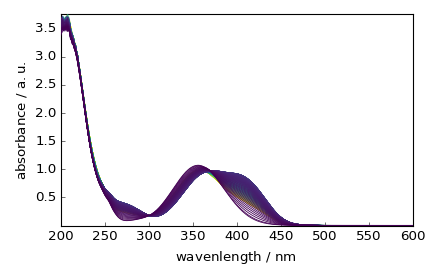

In [2]:
# %%
import numpy as np
import spectrochempy as scp
import matplotlib.pyplot as plt

D = scp.read("http://www.bdagroup.nl/content/Downloads/datasets/18_sb_uv_vis.zip")
for pair in D:
    if pair[1].name == "x9b":
        ds = pair
        break

# %%
D = scp.NDDataset(ds[1][:, 1:].data.T)
D.y = scp.Coord(ds[0].data.squeeze(), title="time", units='min') / 60
D.x = scp.Coord(ds[1][:, 0].data.squeeze(), title="wavenlength / nm")
D.units = "absorbance"
D.title = "absorbance"


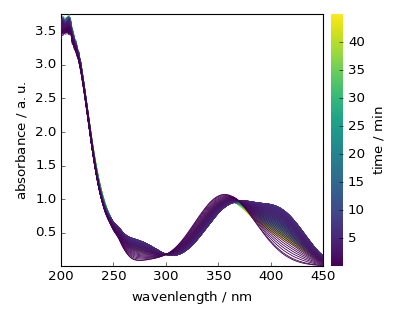

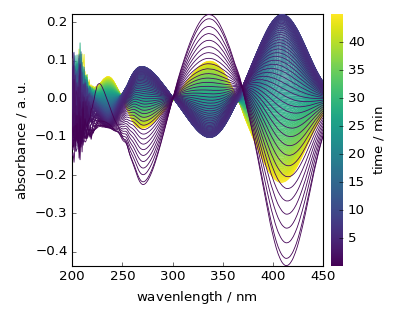

In [7]:
## %% plot difference

_ = D[:,200.:450.].plot(colorbar=True)
scp.show()
_ = (D[:,200.:450.] - D[:,200.:450.].mean(dim=0)).plot(colorbar=True)
scp.show()

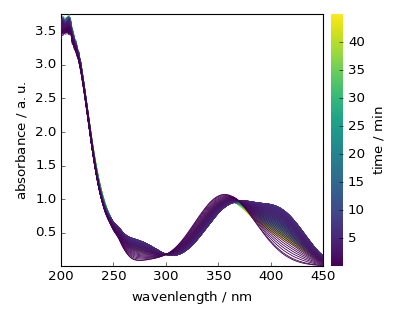

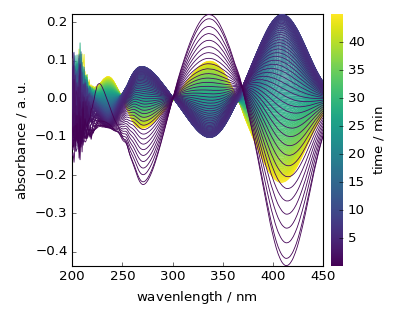

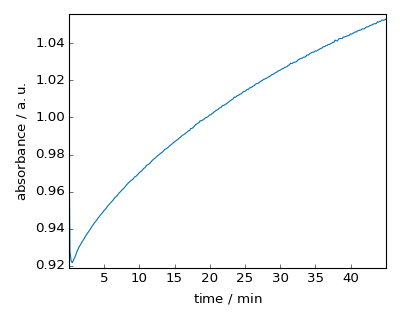

 ERROR | ValueError: 'locs' must be 1D with shape (M,). Your input has shape (2, 3).


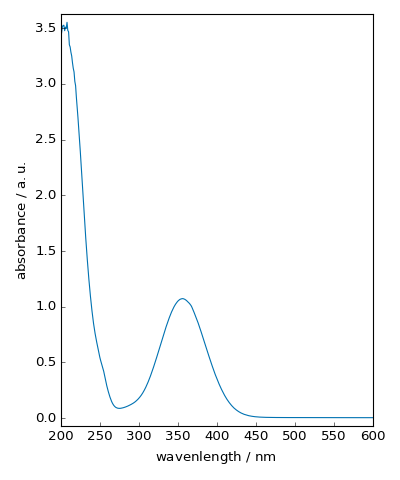

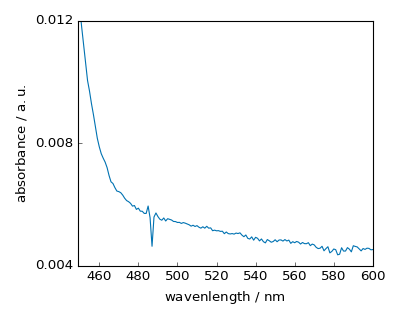

In [6]:


# %%
D[:,240.].plot()
plt.show()

 # %%
prefs = D.preferences  # we will use prefs instead of dataset.preference
prefs.figure.figsize = (5., 6.)
ax = D[0].plot()

# %%
prefs.figure.figsize = (5., 4.)

ax = D[0, 449.:600.].plot()
ax.set_ylim(0.004, 0.012)
ax.set_yticks(plt.yticks(np.arange(4, 16, 4)/1000))
#ax.set_xticks(plt.xticks(np.arange(450, 650, 50)))

prefs.figure.figsize = (5., 3.)
# %%
ax = D[0, 200.:230.].plot()
#ax.set_ylim(0.004, 0.012)
#"ax.set_yticks(plt.yticks(np.arange(4, 16, 4)/1000))

# %%
cov = scp.NDDataset(np.cov(D.T))
cov.title = 'covariance'
cov.set_coordset(D.x, D.x)
cov.preferences.figure.figsize = (6., 5.)
#cov[:450.,:450.].plot(method='map', cmap='Spectral', clevels=50, colorbar=True)
cov[:450.,:450.].plot(method="image", image_cmap="viridis", colorbar=True)

plt.show()

# %%
# Asynchronous change

def row_multiply(array, multiplicator):
    return array * np.repeat(np.atleast_2d(multiplicator), array.shape[0], axis=0)

def col_plus(array, summand):
    return array + np.repeat(np.atleast_2d(summand).T, array.shape[1], axis=1)
def asynch(D):
    data = D.T.data
    meancentered = col_plus(data, - np.mean(data, axis=1))
    times = D.y.data.squeeze()
    disturb = np.hstack((2 * times[0] - times[1], times,
                         2 * times[-1] - times[-2]))
    diffs = disturb[2:] - disturb[:-2]
    hino = np.zeros((times.shape[0], times.shape[0]))
    for row in range(hino.shape[0]):
        for col in range(hino.shape[1]):
            if row != col:
                hino[row, col] = (disturb[col + 2] - disturb[col]) / \
                                 (2 * np.pi * (disturb[col + 1] - disturb[row + 1]))

    zwave = np.dot(hino, meancentered.T)
    return 1 / (times[-1] - times[0]) * np.dot(
        row_multiply(meancentered, diffs), zwave).T


cov = scp.NDDataset(asynch(D))
cov.title = 'covariance'
cov.set_coordset(D.x, D.x)
cov.preferences.figure.figsize = (6., 5.)
#cov[:450.,:450.].plot(method='map', cmap='Spectral', clevels=50, colorbar=True)
cov[:450.,:450.].plot(method="image", image_cmap="viridis", colorbar=True)

plt.show()

# %%

pca = scp.PCA(n_components=5)
pca.fit(D[:,:500.])
pca.loadings.plot()
plt.show()
pca.scores.T.plot()
plt.show()

# %%
pca.printev()

# %%
pca.screeplot()

# %%
dexp = D[:,:500.]
dmean = dexp.mean(dim=0)
pca = scp.PCA(n_components=5)
pca.fit(dexp)

# %%
dhat = scp.dot(pca.scores[:,0], pca.loadings[0]) + dmean.data
dexp.plot(cmap=None, color='dodgerblue')
ax = dhat.plot(cmap=None, color='limegreen', clear=False)
(dexp - dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()
# %%
t = pca.scores[:,1]
p = pca.loadings[1]

dhat += scp.dot(t, p)
dexp.plot(cmap=None, color='dodgerblue')
ax = dhat.plot(cmap=None, color='limegreen', clear=False)
(dexp - dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()

# %%
t = pca.scores[:,2]
p = pca.loadings[2]

dhat += scp.dot(t, p)
dexp.plot(cmap=None, color='dodgerblue')
ax = dhat.plot(cmap=None, color='limegreen', clear=False)
(dexp - dhat).plot(clear=False, cmap=None, color='lightcoral')
ax.set_ylim(-0.2, 4)
scp.show()

# %%
ax = pca.scoreplot(1,2, 3)


# %%

X = scp.read_omnic("irdata//nh4y-activation.spg")
_ = X[:, 4800.:4500.].plot()
x = X[:, 4800.:4500.]
x = x.abc()
x.plot()
scp.show()

# %%
pca = scp.PCA(n_components=3)
pca.fit(x)
xhat = pca.inverse_transform()
xhat.plot()
scp.show()

# %%
efa = scp.EFA(n_components=3)
efa.fit(dexp)
np.log10(efa.f_ev.clip(1e-5)).T.plot(cmap=None, color='dodgerblue')
np.log10(efa.b_ev.clip(1e-5)).T.plot(clear=False, cmap=None, color='limegreen')
scp.show()

#%%
C = efa.transform()
C.T.plot()

# %%




# %%

p = dexp.std(dim=0)/(dexp.mean(dim=0) + 0.03 * np.mean(dexp))
p.plot()
scp.show()

# %%
sim = scp.SIMPLISMA(n_components=3, tol=0.1)
sim.fit(dexp)
sim.St.plot()
scp.show()

# %%
sim.C.T.plot()
scp.show()

# %%
sim.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None);
scp.show()



# %%
ax = (dexp - dhat).plot()
ax.set_ylim(-0.2, 4)

# %%
ax = dexp.plot()
ax.set_ylim(-0.2, 4)

# %%
# MCR ALS, 2 componnents, first and last spectrum as guess

mcr_0 = scp.MCRALS(log_level='INFO')
St0 = scp.concatenate((dexp[0], dexp[-1]), axis=0)
mcr_0 = mcr_0.fit(dexp, St0)

mcr_0.C.T.plot(); scp.show()
mcr_0.St.plot(); scp.show()
mcr_0.plotmerit(); scp.show()

# %%
# MCR ALS, 3 componnents, first, intermediate and last spectrum as guess

mcr_1 = scp.MCRALS(log_level='INFO')
mcr_1.solverConc = 'nnls'
# mcr_1.normSpec = 'euclid'
mcr_1.closureConc = [0,1,2]
St0 = scp.concatenate((dexp[0], dexp[len(dexp.y)//2], dexp[-1]), axis=0)
St0.plot(title="guess spectra"); scp.show()
mcr_1 = mcr_1.fit(dexp, St0)


mcr_1.C.T.plot(); scp.show()
mcr_1.St.plot(); scp.show()
ax = mcr_1.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')
scp.show()

# %%
# MCR ALS, 3 componnents, intensities as guess

C0 = scp.concatenate((dexp[:,340.], dexp[:,260.], dexp[:,240.]), axis=1)
C0.T.plot()

mcr_2 = scp.MCRALS(log_level='INFO')
mcr_2.solverConc = 'nnls'
mcr_2.closureConc = [0,1,2]
mcr_2 = mcr_2.fit(dexp, C0)

mcr_2.C.T.plot()
scp.show()
mcr_2.St.plot()
ax = mcr_2.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')


# %%
# MCR ALS, 3 componnents, EFA

efa = scp.EFA(n_components=3)
efa.fit(dexp)
C0 = efa.transform()
C0.T.plot()


mcr_3 = scp.MCRALS(log_level='INFO')
mcr_3.solverConc = 'nnls'
# mcr_1.normSpec = 'euclid'
mcr_3.closureConc = [0,1,2]
mcr_3 = mcr_2.fit(dexp, C0)

mcr_3.C.T.plot()
mcr_3.St.plot()
ax = mcr_3.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')

# %%
# MCR ALS, 3 componnents, SIMPLISMA

sim = scp.SIMPLISMA(n_components=3, tol=0.01)
sim.fit(dexp)
St0 = sim.St
St0.plot()
scp.show()


mcr_4 = scp.MCRALS(log_level='INFO')
mcr_4.solverConc = 'nnls'
# mcr_1.normSpec = 'euclid'
mcr_4.closureConc = [0,1,2]
mcr_4 = mcr_2.fit(dexp, St0)

mcr_4.C.T.plot()
mcr_4.St.plot()
ax = mcr_4.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')

# %%

reactions = ("A -> B", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.5, 0.05))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)

Ckin = kin.integrate(D.y.data)
_ = mcr_3.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')

# %%
X = D # [:, 300.0:500.0]
param_to_optimize = {"k[0]": 0.5, "k[1]": 0.05}
mcr_5 = scp.MCRALS()
mcr_5.hardConc = [0, 1, 2]
mcr_5.getConc = kin.fit_to_concentrations
mcr_5.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_5.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_5.fit(X, Ckin)

# %%
_ = mcr_5.C.T.plot()
_ = mcr_5.C_constrained.T.plot(clear=False, ls='dashed')
scp.show()

# %%
mcr_5.St.plot()
scp.show()
ax = mcr_5.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')


# %%
# Final model, reversible reactions

reactions = ("A -> B", "B -> A", "B -> C")
species_concentrations = {"A": 1.0, "B": 0.0, "C": 0.0}
k0 = np.array((0.23, 0.0612, 0.0383))
kin = scp.ActionMassKinetics(reactions, species_concentrations, k0)

Ckin = kin.integrate(D.y.data)
_ = mcr_5.C.T.plot()
_ = Ckin.T.plot(clear=False, ls='dashed')


# %%
X = D # [:, 300.0:500.0]
param_to_optimize = {"k[0]": 0.23, "k[1]": 0.0612, "k[2]": 0.0383}
mcr_6 = scp.MCRALS()
mcr_6.hardConc = [0, 1, 2]
mcr_6.getConc = kin.fit_to_concentrations
mcr_6.argsGetConc = ([0, 1, 2], [0, 1, 2], param_to_optimize)
mcr_6.kwargsGetConc = {"ivp_solver_kwargs": {"return_NDDataset": False}}

mcr_6.fit(X, Ckin)

# %%
_ = mcr_6.C.T.plot()
_ = mcr_6.C_constrained.T.plot(clear=False, ls='dashed')


# %%
mcr_5.St.plot()
scp.show()

# %%
ax = mcr_5.plotmerit(colors=('dodgerblue','limegreen', 'lightcoral'), ls='solid', cmap=None)
ax.set_title('')